# Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import numpy as np 
import xgboost as xgb
import joblib
import re
import os
from math import sqrt
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Visualization Style

In [3]:
formatter = ticker.StrMethodFormatter('Rp.{x:,.0f}')
sns.set_theme(style='darkgrid')
sns.set_palette("deep")
mpl.rcParams['font.family'] = 'sans'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Data Collecting

In [4]:
import sys
sys.path.append('..')

from scripts import get_data_from_mongo

In [5]:
df_import = get_data_from_mongo.get_data_mongo('tanah_bali_clean_new')
df_import = pd.DataFrame(df_import)

----------------------------------------------
Connected to db db_tanah_bali
Total documents get: 23640
Dissconnected!


In [6]:
df = df_import.copy()
df.head()

,_id,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat
0,665fbe1439acabdc6cb745a2,2024-05-19,200.0,8.000000e+08,4000000.0,Nusa Dua,Badung,5.298317,20.500122,15.201805,small
1,665fbe1439acabdc6cb745a3,2024-03-20,400.0,2.800000e+09,7000000.0,Canggu,Badung,5.991465,21.752885,15.761421,medium
2,665fbe1439acabdc6cb745a4,2024-04-28,300.0,3.000000e+09,10000000.0,Canggu,Badung,5.703782,21.821878,16.118096,small
3,665fbe1439acabdc6cb745a5,2024-05-19,6300.0,9.450000e+10,15000000.0,Kuta,Badung,8.748305,25.271866,16.523561,large
4,665fbe1439acabdc6cb745a6,2024-05-19,2000.0,7.900000e+09,3950000.0,Kelating,Tabanan,7.600902,22.790129,15.189226,large


# Data Preparation

### Check Dataframe

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23640 entries, 0 to 23639
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   _id               23640 non-null  object        
 1   date              23640 non-null  datetime64[ns]
 2   land_area         23640 non-null  float64       
 3   price_total       23640 non-null  float64       
 4   price_per_m2      23640 non-null  float64       
 5   subdistrict       23640 non-null  object        
 6   regency           23640 non-null  object        
 7   log_land_area     23640 non-null  float64       
 8   log_price_total   23640 non-null  float64       
 9   log_price_per_m2  23640 non-null  float64       
 10  land_area_cat     23640 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 2.0+ MB


### Delete Unnecessary Column

In [8]:
df = df.drop(columns='_id', axis=1)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat
0,2024-05-19,200.0,8.000000e+08,4000000.0,Nusa Dua,Badung,5.298317,20.500122,15.201805,small
1,2024-03-20,400.0,2.800000e+09,7000000.0,Canggu,Badung,5.991465,21.752885,15.761421,medium
2,2024-04-28,300.0,3.000000e+09,10000000.0,Canggu,Badung,5.703782,21.821878,16.118096,small
3,2024-05-19,6300.0,9.450000e+10,15000000.0,Kuta,Badung,8.748305,25.271866,16.523561,large
4,2024-05-19,2000.0,7.900000e+09,3950000.0,Kelating,Tabanan,7.600902,22.790129,15.189226,large


### Change Datatype of Date Column

In [9]:
df['date'] = pd.to_datetime(df['date'])

# EDA (Exploratory Data Analysis)

### Summary Numerical Statistics

In [10]:
df.describe()

,date,land_area,price_total,price_per_m2,log_land_area,log_price_total,log_price_per_m2
count,23640,23640.000000,2.364000e+04,2.364000e+04,23640.000000,23640.000000,23640.000000
mean,2024-02-29 17:13:13.096446464,3363.688494,2.225314e+10,8.657794e+06,7.017580,22.678980,15.661400
min,2022-12-11 00:00:00,20.000000,1.100000e+08,5.517241e+05,2.995732,18.515991,13.220803
25%,2024-01-20 00:00:00,400.000000,2.550000e+09,3.746426e+06,5.991465,21.659359,15.136313
50%,2024-02-19 00:00:00,1000.000000,6.690000e+09,6.500000e+06,6.907755,22.623880,15.687313
75%,2024-04-19 00:00:00,2800.000000,1.800000e+10,1.200000e+07,7.937375,23.613638,16.300417
max,2024-05-19 00:00:00,77000.000000,5.355000e+11,7.500000e+07,11.251561,27.006467,18.132999
std,NaN,7470.241814,5.250879e+10,7.030472e+06,1.392090,1.463887,0.826655


### Summary Categorical Statistics

In [11]:
df.describe(include=object)

,subdistrict,regency,land_area_cat
count,23640,23640,23640
unique,404,9,3
top,Canggu,Badung,medium
freq,1812,12692,10271


### Land Area Analysis

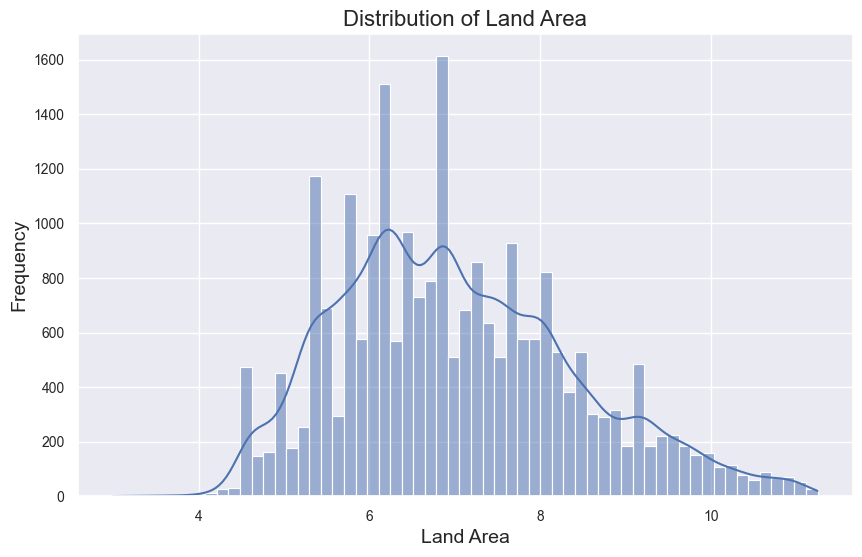

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_land_area'], kde=True)
plt.title('Distribution of Land Area')
plt.xlabel('Land Area')
plt.ylabel('Frequency')
plt.show()

### Total Price Distribution

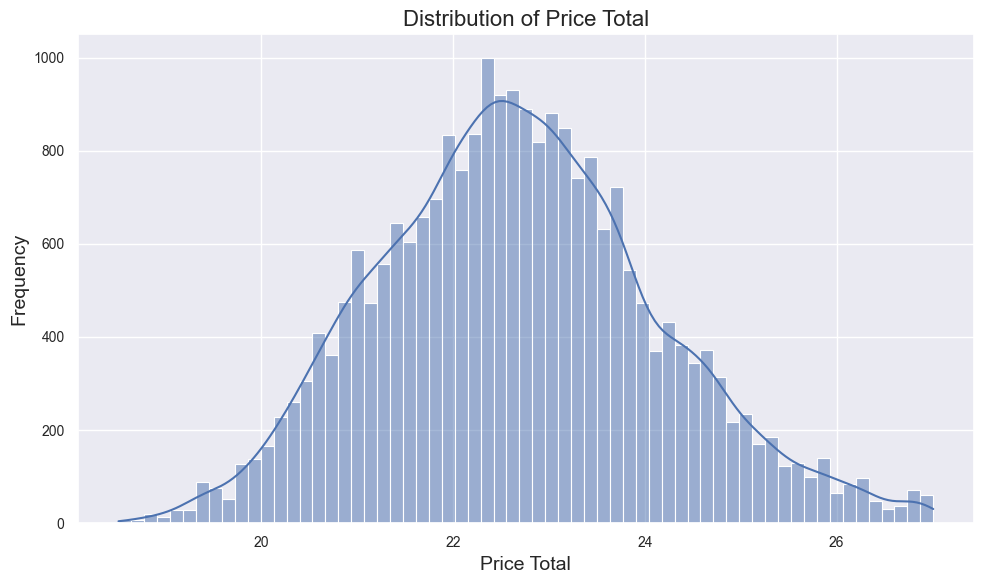

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price_total'], kde=True)
plt.title('Distribution of Price Total')
plt.xlabel('Price Total')
plt.ylabel('Frequency')
# plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Price per m2 Distribution

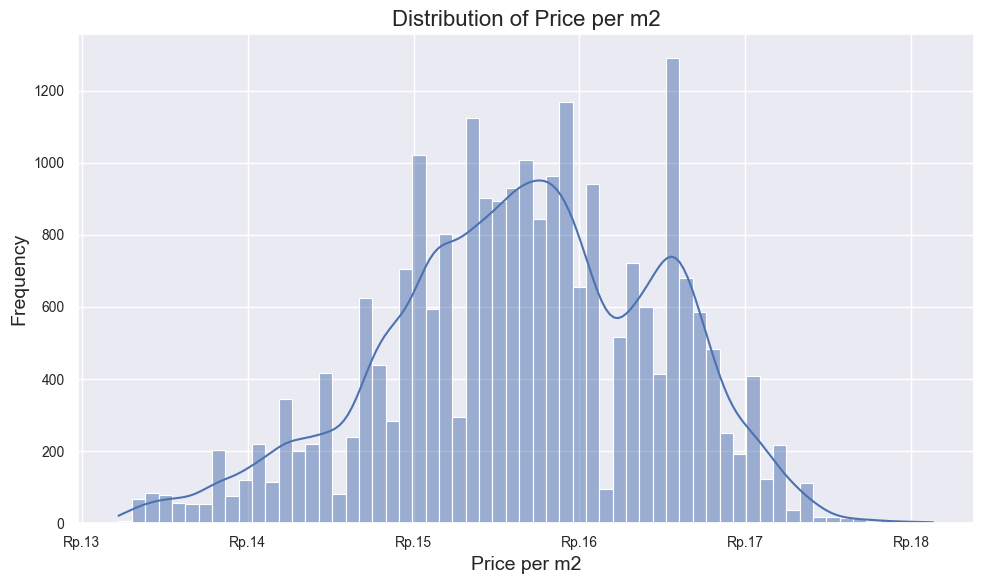

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price_per_m2'], kde=True)
plt.title('Distribution of Price per m2')
plt.xlabel('Price per m2')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Subdistrict Regency

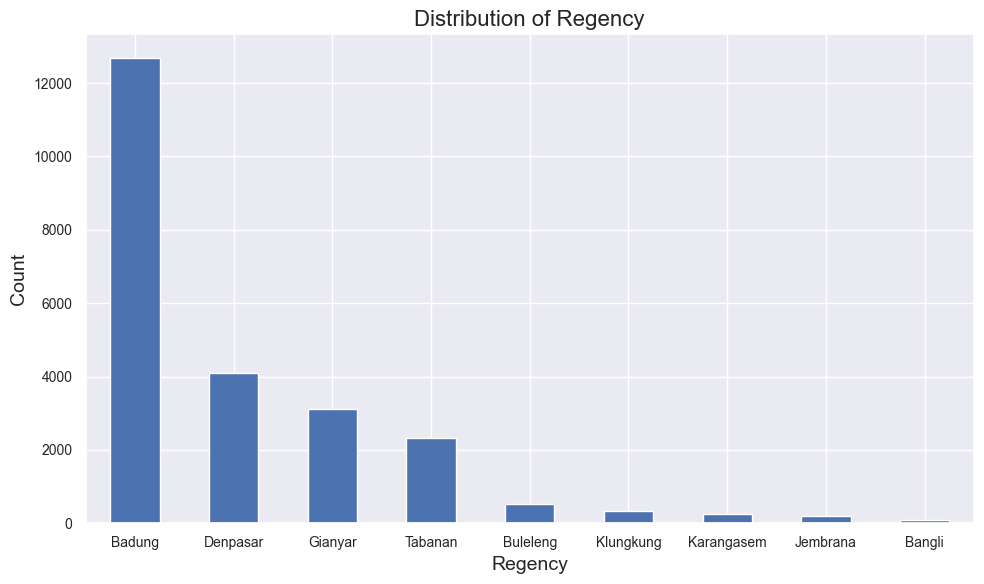

In [15]:
plt.figure(figsize=(10, 6))
df['regency'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of Regency')
plt.xlabel('Regency')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
df['regency'].value_counts().to_frame().T

regency,Badung,Denpasar,Gianyar,Tabanan,Buleleng,Klungkung,Karangasem,Jembrana,Bangli
count,12692,4103,3123,2327,522,335,256,185,97


### Land Area Category Distribution

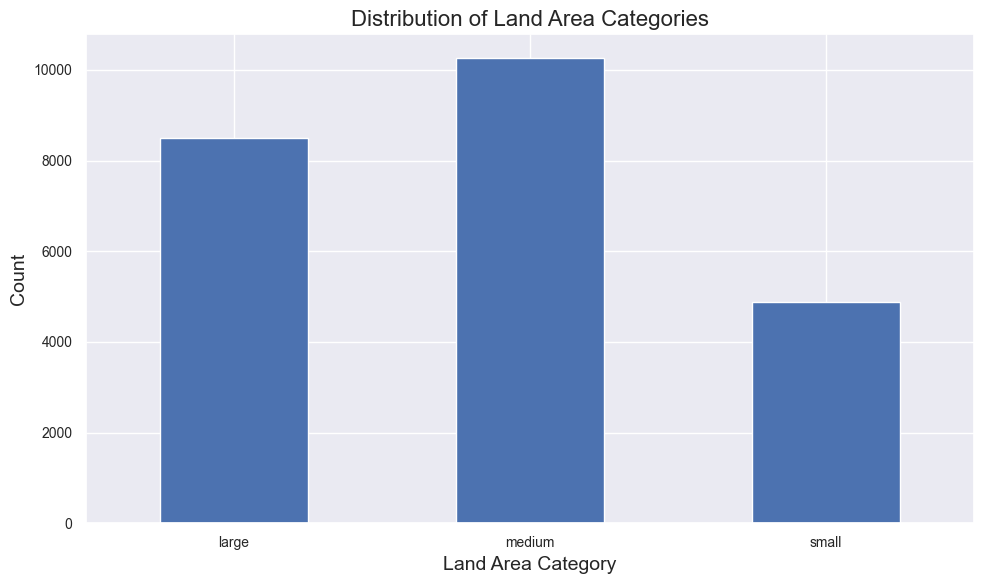

In [17]:
plt.figure(figsize=(10, 6))
df['land_area_cat'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Land Area Categories')
plt.xlabel('Land Area Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
df['land_area_cat'].value_counts().to_frame().T

land_area_cat,medium,large,small
count,10271,8496,4873


### Showing Price Total Over Time

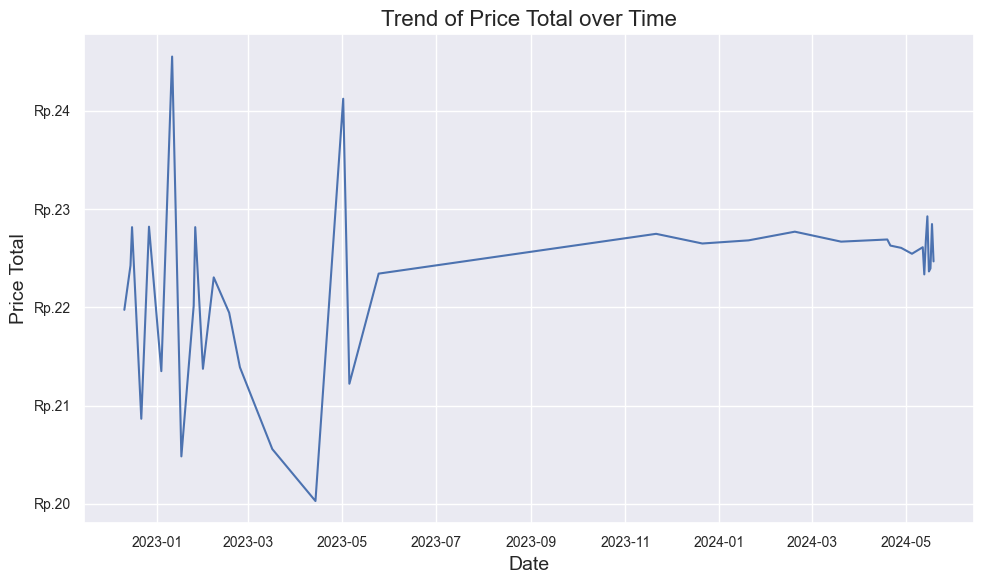

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='log_price_total', data=df, errorbar=None)
plt.title('Trend of Price Total over Time')
plt.xlabel('Date')
plt.ylabel('Price Total')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Price per m2 Over Time

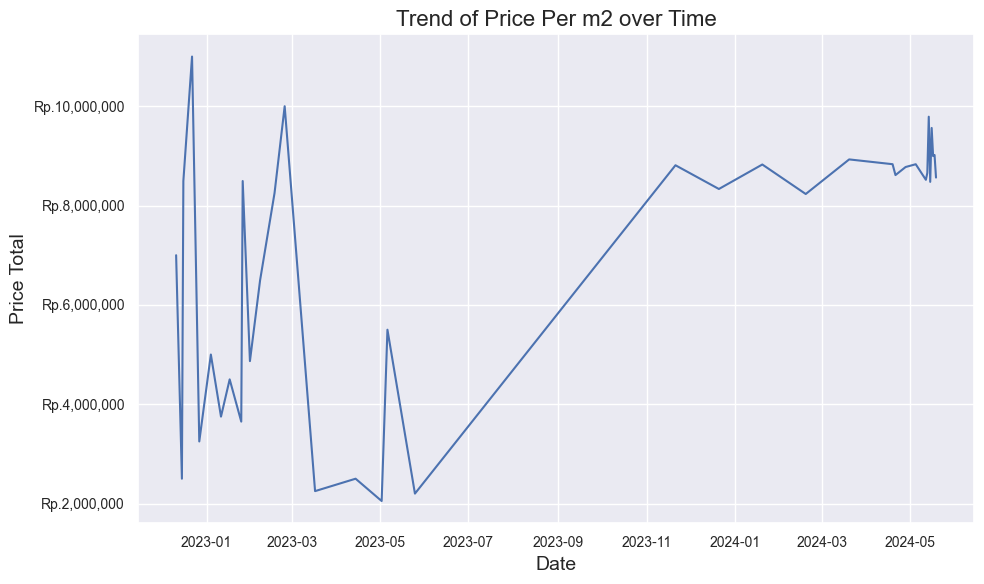

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='price_per_m2', data=df, errorbar=None)
plt.title('Trend of Price Per m2 over Time')
plt.xlabel('Date')
plt.ylabel('Price Total')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Price Total and Regency  

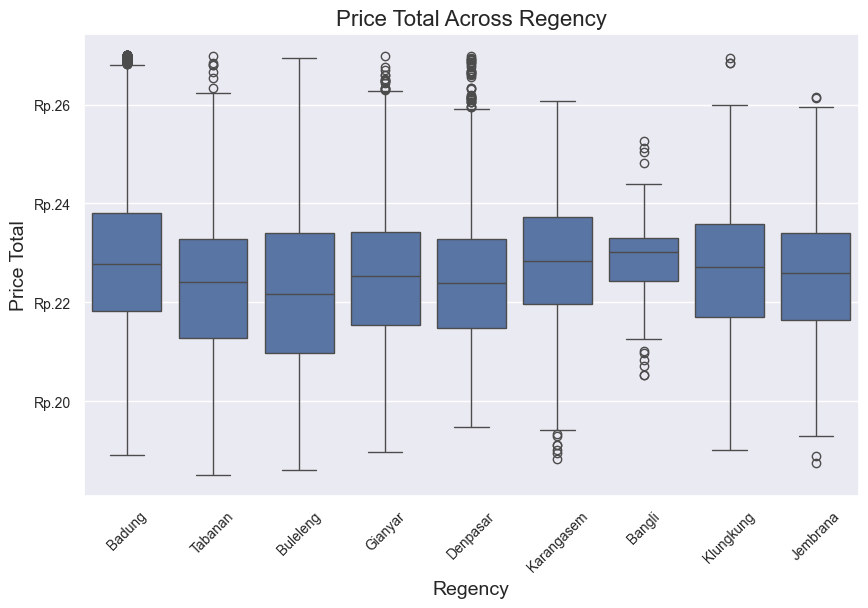

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='regency', y='log_price_total', data=df)
plt.title('Price Total Across Regency')
plt.xlabel('Regency')
plt.ylabel('Price Total')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [22]:
price_sum_by_regency = df.groupby('regency')['log_price_total'].sum()
price_sum_by_regency = price_sum_by_regency.sort_values(ascending=False)
price_sum_by_regency

regency
Badung        290354.792583
Denpasar       92132.344357
Gianyar        70418.205050
Tabanan        51903.315168
Buleleng       11534.086460
Klungkung       7582.094314
Karangasem      5824.502374
Jembrana        4163.463536
Bangli          2218.291233
Name: log_price_total, dtype: float64

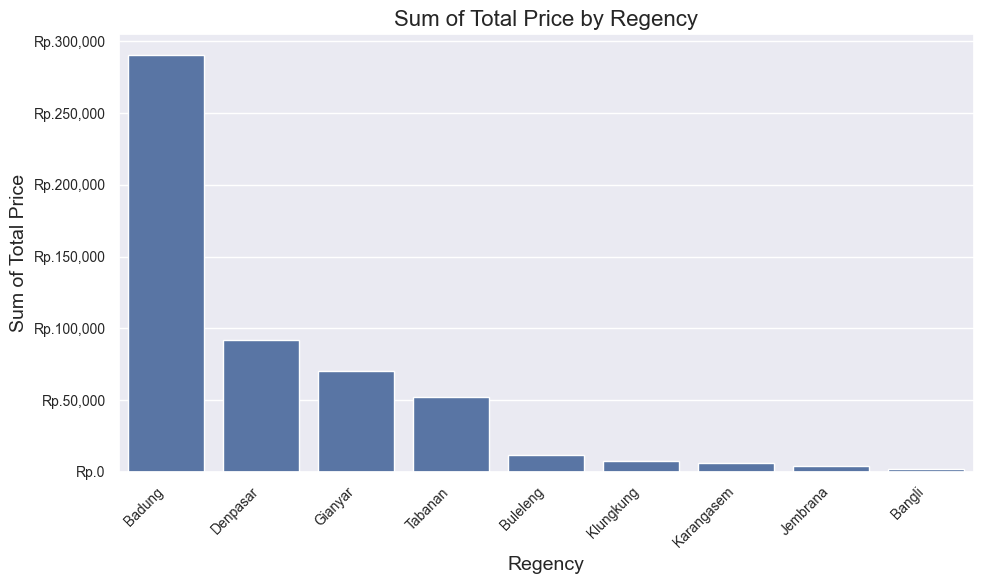

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_sum_by_regency.index, y=price_sum_by_regency.values)
plt.title('Sum of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Sum of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

In [24]:
price_mean_by_regency = df.groupby('regency')['price_total'].mean()
price_mean_by_regency = price_mean_by_regency.sort_values(ascending=False)
price_mean_by_regency

regency
Badung        2.813324e+10
Klungkung     1.986459e+10
Karangasem    1.771496e+10
Gianyar       1.757699e+10
Jembrana      1.743830e+10
Denpasar      1.471079e+10
Tabanan       1.380939e+10
Bangli        1.345734e+10
Buleleng      1.128426e+10
Name: price_total, dtype: float64

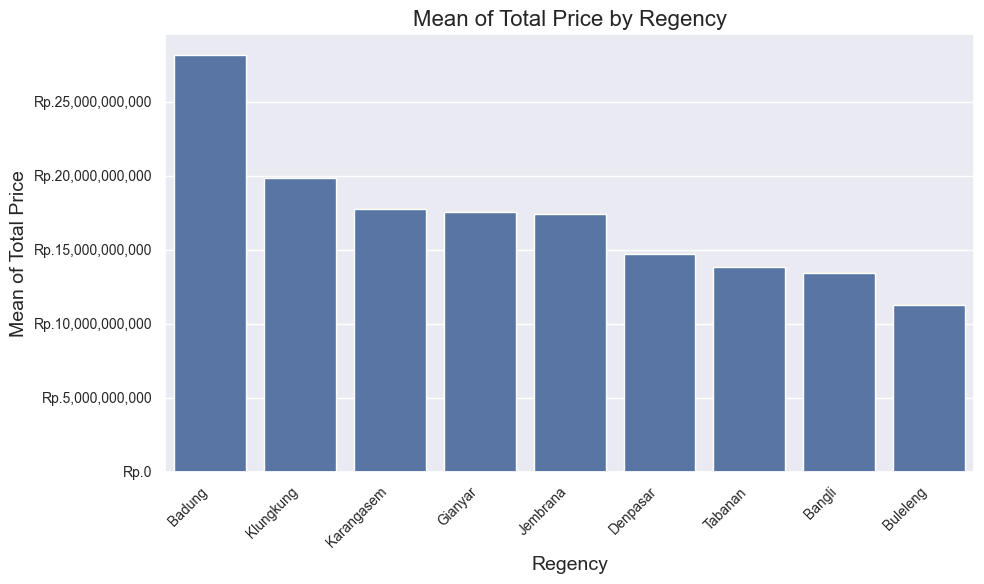

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_mean_by_regency.index, y=price_mean_by_regency.values)
plt.title('Mean of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Mean of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Price per m2 and Regency  

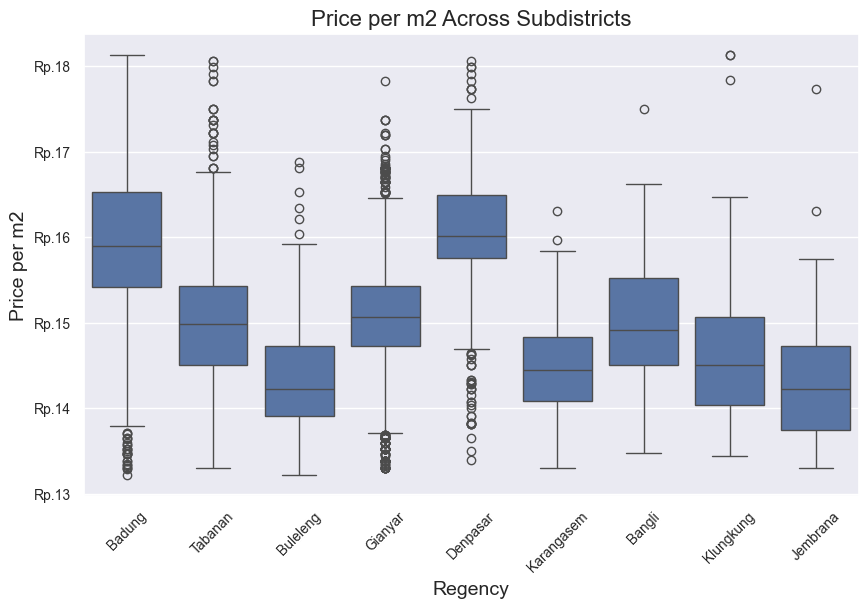

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='regency', y='log_price_per_m2', data=df)
plt.title('Price per m2 Across Subdistricts')
plt.xlabel('Regency')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

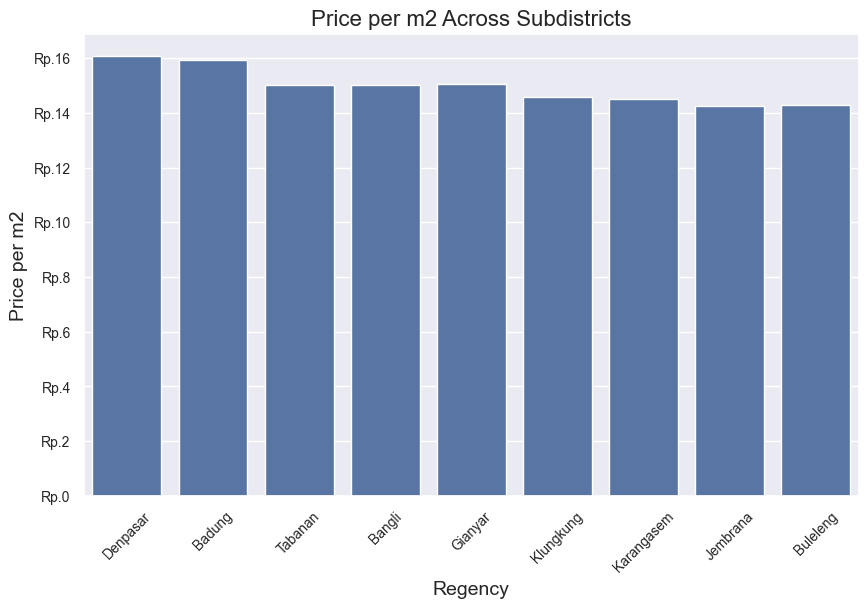

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='regency', y='log_price_per_m2', data=df, order=df.groupby('regency')['price_per_m2'].mean().sort_values(ascending=False).index, errorbar=None)
plt.title('Price per m2 Across Subdistricts')
plt.xlabel('Regency')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [28]:
pricem2_sum_by_regency = df.groupby('regency')['price_per_m2'].sum()
pricem2_sum_by_regency = pricem2_sum_by_regency.sort_values(ascending=False)
pricem2_sum_by_regency

regency
Badung        1.321124e+11
Denpasar      4.555264e+10
Gianyar       1.317797e+10
Tabanan       1.029229e+10
Klungkung     1.079135e+09
Buleleng      1.051856e+09
Karangasem    5.892445e+08
Bangli        4.208718e+08
Jembrana      3.937970e+08
Name: price_per_m2, dtype: float64

In [29]:
pricem2_mean_by_regency = df.groupby('regency')['price_per_m2'].mean()
pricem2_mean_by_regency = pricem2_mean_by_regency.sort_values(ascending=False)
pricem2_mean_by_regency

regency
Denpasar      1.110228e+07
Badung        1.040911e+07
Tabanan       4.422987e+06
Bangli        4.338885e+06
Gianyar       4.219650e+06
Klungkung     3.221300e+06
Karangasem    2.301736e+06
Jembrana      2.128633e+06
Buleleng      2.015050e+06
Name: price_per_m2, dtype: float64

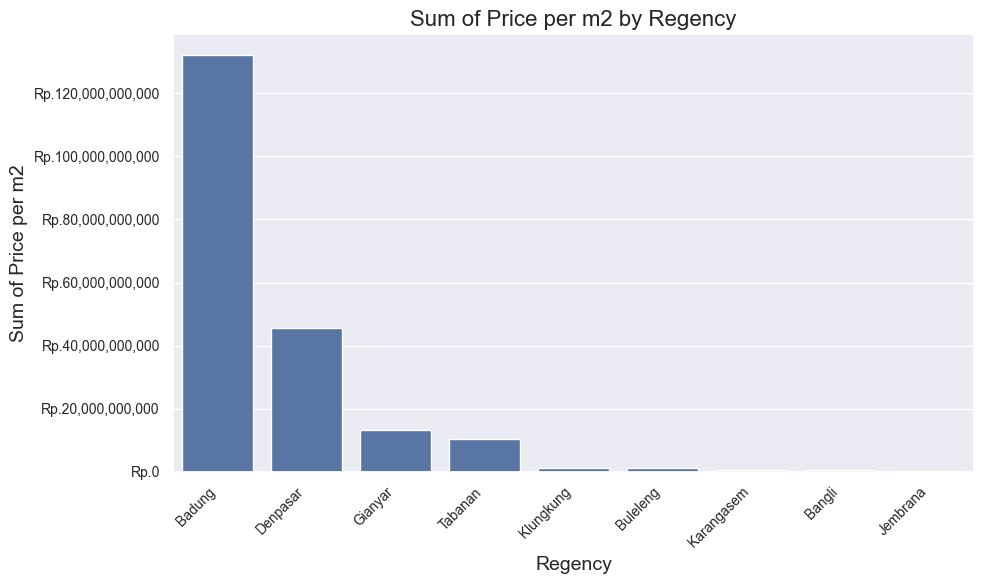

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pricem2_sum_by_regency.index, y=pricem2_sum_by_regency.values)
plt.title('Sum of Price per m2 by Regency')
plt.xlabel('Regency')
plt.ylabel('Sum of Price per m2')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

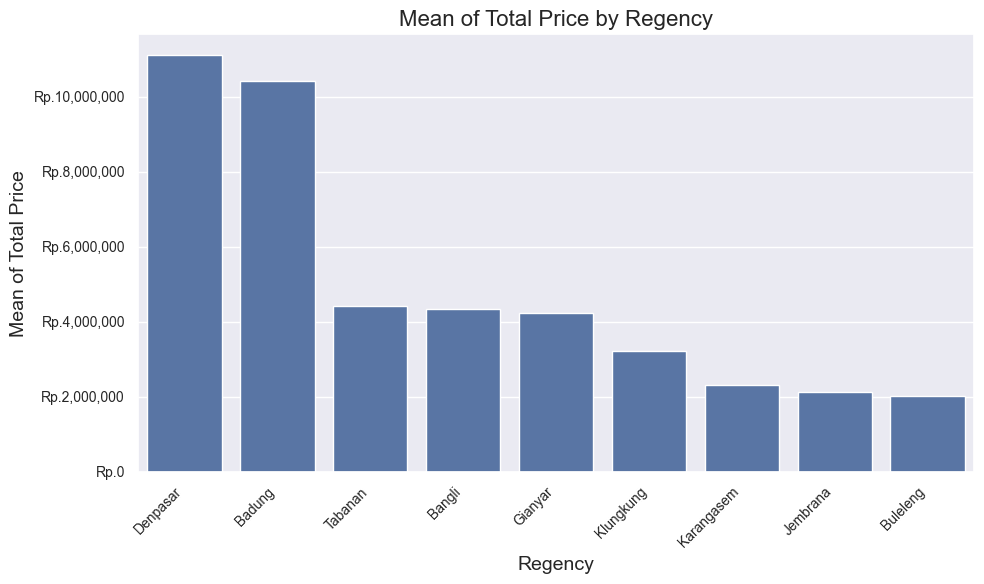

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pricem2_mean_by_regency.index, y=pricem2_mean_by_regency.values)
plt.title('Mean of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Mean of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Land Area and Price Total

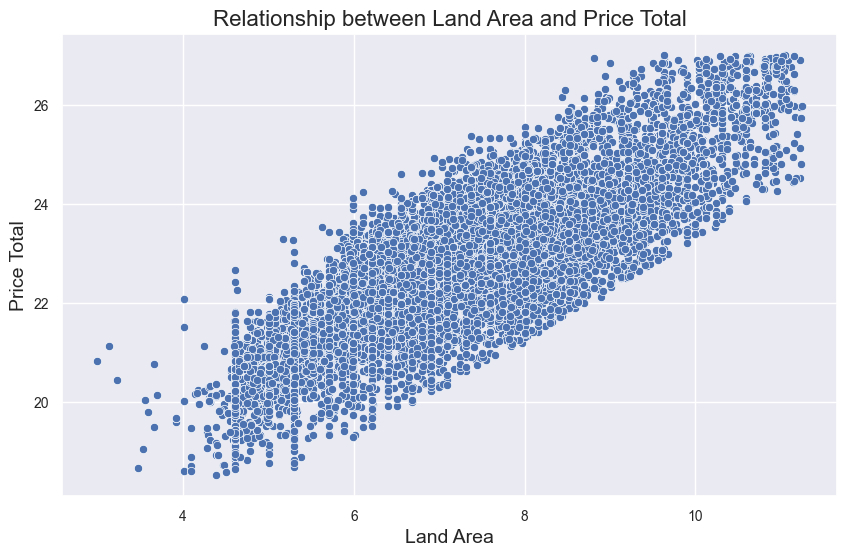

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_land_area', y='log_price_total', data=df)
plt.title('Relationship between Land Area and Price Total')
plt.xlabel('Land Area')
plt.ylabel('Price Total')
plt.show()

### Correlation Analysis

- Sort Price Total Value by Regency

In [33]:
price_sum_by_regency = df.groupby('regency')['log_price_total'].sum()
price_sum_by_regency.sort_values(ascending=False)

regency
Badung        290354.792583
Denpasar       92132.344357
Gianyar        70418.205050
Tabanan        51903.315168
Buleleng       11534.086460
Klungkung       7582.094314
Karangasem      5824.502374
Jembrana        4163.463536
Bangli          2218.291233
Name: log_price_total, dtype: float64

- Label Encoding on Regency Column

In [34]:
sorted_regencies = price_sum_by_regency.sort_values(ascending=True).index
encoding_dict = {regency: rank for rank, regency in enumerate(sorted_regencies, start=1)}

In [35]:
df['regency_encoded'] = df['regency'].map(encoding_dict)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded
0,2024-05-19,200.0,8.000000e+08,4000000.0,Nusa Dua,Badung,5.298317,20.500122,15.201805,small,9
1,2024-03-20,400.0,2.800000e+09,7000000.0,Canggu,Badung,5.991465,21.752885,15.761421,medium,9
2,2024-04-28,300.0,3.000000e+09,10000000.0,Canggu,Badung,5.703782,21.821878,16.118096,small,9
3,2024-05-19,6300.0,9.450000e+10,15000000.0,Kuta,Badung,8.748305,25.271866,16.523561,large,9
4,2024-05-19,2000.0,7.900000e+09,3950000.0,Kelating,Tabanan,7.600902,22.790129,15.189226,large,6


- Sort Subdistrict Column by Sum of Price Total

In [36]:
price_sum_by_subd = df.groupby('subdistrict')['log_price_total'].sum()
price_sum_by_subd.sort_values(ascending=False)

subdistrict
Canggu               41648.132801
Ungasan              34546.318127
Jimbaran             34030.304514
Ubud                 28059.218991
Nusa Dua             21387.725541
                         ...     
Temesi                  19.583832
Sangsit                 19.519293
Sinabun                 19.113828
Penglatan               18.915377
Tegalbadeng Timur       18.890684
Name: log_price_total, Length: 404, dtype: float64

- Label Encoding on Subdistrict Column

In [37]:
sorted_subd = price_sum_by_subd.sort_values(ascending=True).index
encoding_subd = {regency: rank for rank, regency in enumerate(sorted_subd, start=1)}

In [38]:
df['subdistrict_encoded'] = df['subdistrict'].map(encoding_subd)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded
0,2024-05-19,200.0,8.000000e+08,4000000.0,Nusa Dua,Badung,5.298317,20.500122,15.201805,small,9,400
1,2024-03-20,400.0,2.800000e+09,7000000.0,Canggu,Badung,5.991465,21.752885,15.761421,medium,9,404
2,2024-04-28,300.0,3.000000e+09,10000000.0,Canggu,Badung,5.703782,21.821878,16.118096,small,9,404
3,2024-05-19,6300.0,9.450000e+10,15000000.0,Kuta,Badung,8.748305,25.271866,16.523561,large,9,395
4,2024-05-19,2000.0,7.900000e+09,3950000.0,Kelating,Tabanan,7.600902,22.790129,15.189226,large,6,351


- Sort Land Area Category by Sum of Price Total

In [39]:
price_sum_by_landcat = df.groupby('land_area_cat')['log_price_total'].sum()
price_sum_by_landcat.sort_values(ascending=False)

land_area_cat
medium    230558.991201
large     203368.609192
small     102203.494682
Name: log_price_total, dtype: float64

- Label Encoding on Land Area Category Column

In [40]:
sorted_land_area = price_sum_by_landcat.sort_values(ascending=True).index
encoding_land_area = {landcat: rank for rank, landcat in enumerate(sorted_land_area, start=1)}

In [41]:
df['land_area_cat_encoded'] = df['land_area_cat'].map(encoding_land_area)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,8.000000e+08,4000000.0,Nusa Dua,Badung,5.298317,20.500122,15.201805,small,9,400,1
1,2024-03-20,400.0,2.800000e+09,7000000.0,Canggu,Badung,5.991465,21.752885,15.761421,medium,9,404,3
2,2024-04-28,300.0,3.000000e+09,10000000.0,Canggu,Badung,5.703782,21.821878,16.118096,small,9,404,1
3,2024-05-19,6300.0,9.450000e+10,15000000.0,Kuta,Badung,8.748305,25.271866,16.523561,large,9,395,2
4,2024-05-19,2000.0,7.900000e+09,3950000.0,Kelating,Tabanan,7.600902,22.790129,15.189226,large,6,351,2


- Backup Dataframe

In [42]:
df_encoded = df.copy()
df_encoded.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,8.000000e+08,4000000.0,Nusa Dua,Badung,5.298317,20.500122,15.201805,small,9,400,1
1,2024-03-20,400.0,2.800000e+09,7000000.0,Canggu,Badung,5.991465,21.752885,15.761421,medium,9,404,3
2,2024-04-28,300.0,3.000000e+09,10000000.0,Canggu,Badung,5.703782,21.821878,16.118096,small,9,404,1
3,2024-05-19,6300.0,9.450000e+10,15000000.0,Kuta,Badung,8.748305,25.271866,16.523561,large,9,395,2
4,2024-05-19,2000.0,7.900000e+09,3950000.0,Kelating,Tabanan,7.600902,22.790129,15.189226,large,6,351,2


- Delete the Categorical Column

In [43]:
df = df_encoded.copy()

df = df.drop(columns=['regency', 'subdistrict', 'land_area_cat'])
df.head()

,date,land_area,price_total,price_per_m2,log_land_area,log_price_total,log_price_per_m2,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,8.000000e+08,4000000.0,5.298317,20.500122,15.201805,9,400,1
1,2024-03-20,400.0,2.800000e+09,7000000.0,5.991465,21.752885,15.761421,9,404,3
2,2024-04-28,300.0,3.000000e+09,10000000.0,5.703782,21.821878,16.118096,9,404,1
3,2024-05-19,6300.0,9.450000e+10,15000000.0,8.748305,25.271866,16.523561,9,395,2
4,2024-05-19,2000.0,7.900000e+09,3950000.0,7.600902,22.790129,15.189226,6,351,2


- Correlation Matrix of Dataframe

In [44]:
if 'date' in df.columns:
    # Ensure the Date column is of datetime type
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Extract year, month, and day from the Date column
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    # Drop the Date column as it's now redundant
    df.drop('date', axis=1, inplace=True)

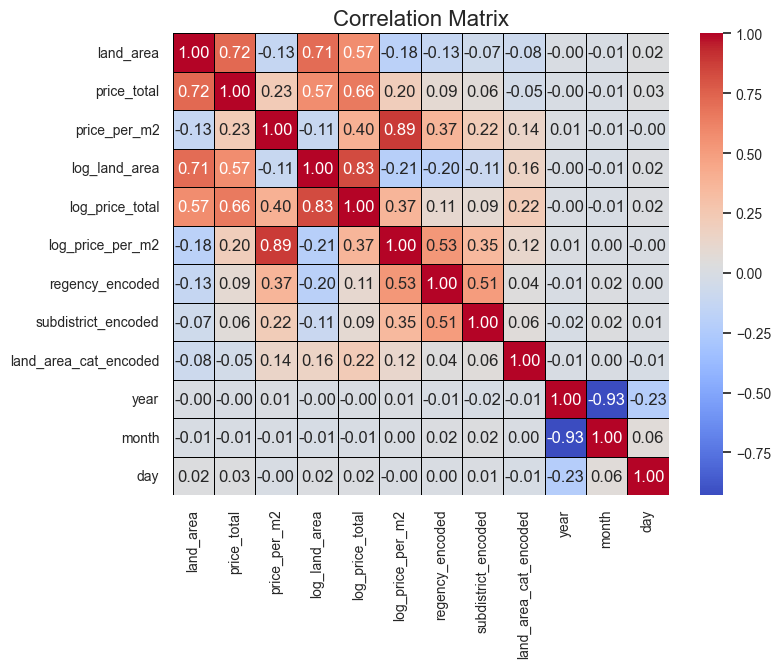

In [45]:
correlation_mat = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix")
plt.show()

In [46]:
target_corr = correlation_mat['log_price_per_m2'].drop('log_price_per_m2')
print("Correlation with 'Price per m2':")
print(target_corr)

Correlation with 'Price per m2':
land_area               -0.184968
price_total              0.202731
price_per_m2             0.885888
log_land_area           -0.207820
log_price_total          0.367072
regency_encoded          0.525482
subdistrict_encoded      0.346148
land_area_cat_encoded    0.123235
year                     0.005537
month                    0.003252
day                     -0.001783
Name: log_price_per_m2, dtype: float64


In [47]:
correlation_threshold = 0.3
selected_features = target_corr[target_corr.abs() > correlation_threshold].index.tolist()

print("Selected features based on correlation:")
print(selected_features)

Selected features based on correlation:
['price_per_m2', 'log_price_total', 'regency_encoded', 'subdistrict_encoded']


# Model Building

### Select Features

In [48]:
features = ['year', 'month', 'day', 'regency_encoded', 'subdistrict_encoded']
# if 'Year' in df_copy.columns and 'Month' in df_copy.columns and 'Day' in df_copy.columns:
#     features.extend(['Year', 'Month', 'Day'])

target = 'log_price_per_m2'

X = df[features]
y = df[target]

### Split Dataset

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost Model

In [55]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
# params = {
#     'objective': 'reg:squarederror',
#     'colsample_bytree': 0.3,
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'alpha': 10,
#     'n_estimators': 100
# }

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the model
num_round = 10000
model = xgb.train(params, dtrain, num_round)

c:\Users\Wahpram\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


- Training Model

In [56]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Testing Model

In [58]:
# y_pred = model.predict(dtest)
y_pred = model.predict(X_test)

# # Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
# msle = mean_squared_log_error(y_test, y_pred) 
# rmse = mse ** 0.5

# print(f"RMSE: {rmse}")

rmse = mean_squared_error(y_test, y_pred, squared=False)
# rmsle = sqrt(msle)

print(f"RMSE of the base model: {rmse:.3f}")
print(f"MSE of the base model: {mse:.3f}")
# print(f"MSE of the base model: {rmsle:.3f}")

RMSE of the base model: 0.561
MSE of the base model: 0.315


### Random Forset Model

- Training Model

In [60]:
# Fitting Random Forest Regression to the dataset
rfr_model = RandomForestRegressor(n_estimators=1000, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
rfr_model.fit(X, y)

RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=0)

- Model Result

In [61]:
# Access the OOB Score
oob_score = rfr_model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = rfr_model.predict(X)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.5653538514137137
Mean Squared Error: 0.24936046402031917
R-squared: 0.6350805828353098


### Export Models and Encoders

In [63]:
joblib.dump(rfr_model, '../models/rfr_model.pkl')
joblib.dump(model, '../models/xgboost_model.pkl')
joblib.dump(encoding_subd, '../models/subdistrict_encode.pkl')
joblib.dump(encoding_dict, '../models/regency_encode.pkl')

['../models/regency_encode.pkl']

### Predicting New Input Data by XGBoost Model

In [77]:
# Function to get user input for new data
model = joblib.load('../models/xgboost_model.pkl')
subdistrict_label_encoder = joblib.load('../models/subdistrict_encode.pkl')
regency_label_encoder = joblib.load('../models/regency_encode.pkl')

def get_new_input():
    day = float(input("Enter the day: "))
    month = float(input("Enter the month: "))
    year = float(input("Enter the year: "))
    regency = input("Enter the regency: ")
    subdistrict = input("Enter the subdistrict: ")
    
    new_data = {
        'year': [year],
        'month': [month],
        'day': [day],
        'subdistrict': [subdistrict],
        'regency': [regency]
    }
    return pd.DataFrame(new_data)

# Get new data from user input
new_df = get_new_input()

# Encoding categorical features for new data
new_df['regency_encoded'] = new_df['regency'].map(regency_label_encoder)
new_df['subdistrict_encoded'] = new_df['subdistrict'].map(subdistrict_label_encoder)

# Dropping non-numeric columns
new_df.drop(['subdistrict', 'regency'], axis=1, inplace=True)

# Ensure the new data has the same feature columns as the training data
# X_new = xgb.DMatrix(new_df)

# Make predictions
new_predictions = model.predict(new_df)
new_predictions = np.exp(new_predictions[0])


In [75]:
# Print the predictions
print("Predicted price per m2: Rp{:,.2f}".format(new_predictions))

Predicted price per m2: Rp2,651,654.25


In [78]:
rfr_model = joblib.load('../models/rfr_model.pkl')
rfr_pred = rfr_model.predict(new_df)
rfr_pred = np.exp(rfr_pred[0])

In [79]:
print("Predicted price per m2: Rp{:,.2f}".format(rfr_pred))

Predicted price per m2: Rp2,312,057.76
